# NER Avanzado con EntityLinker - Extracción de Entidades Médicas

**Asignatura:** Transformers del Lenguaje en Salud (UPCH)

## Objetivo

Crear un sistema completo de NER que:
- ✅ Combina múltiples modelos (Hugging Face + scispacy)
- ✅ Vincula entidades a bases de conocimiento médico (UMLS, RxNorm)
- ✅ Clasifica automáticamente: Enfermedades, Síntomas, Medicamentos
- ✅ Enriquece con definiciones, sinónimos y IDs normalizados
- ✅ Detecta contexto (antecedentes, negación, certeza)

## 1️⃣ Instalación de Dependencias

**Nota:** La primera ejecución tomará varios minutos debido a las descargas.

In [1]:
%pip install -q matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Instalación de paquetes base
%pip install -q transformers torch pandas matplotlib
%pip install -q scispacy
%pip install -q spacy>=3.7.0,<3.8.0

print("✅ Paquetes base instalados")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: 3.7.0, not found
Note: you may need to restart the kernel to use updated packages.
✅ Paquetes base instalados


In [2]:
# Descarga de modelos scispacy
%pip install -q https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_scibert-0.5.4.tar.gz
%pip install -q https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz

print("✅ Modelos scispacy descargados")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ Modelos scispacy descargados


## 2️⃣ Importación de Librerías

In [3]:
import json
import re
from datetime import datetime
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Transformers (Hugging Face)
from transformers import pipeline

# Spacy y scispacy
import spacy
import scispacy
from scispacy.linking import EntityLinker
from scispacy.abbreviation import AbbreviationDetector

# Visualización
import pandas as pd
import matplotlib.pyplot as plt

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 3️⃣ Carga de Modelos NER

Cargamos múltiples modelos para maximizar la cobertura de entidades detectadas.

In [4]:
# Modelo 1: Hugging Face - Biomedical NER (General)
print("⏳ Cargando modelo Hugging Face...")
ner_hf = pipeline(
    "token-classification",
    model="d4data/biomedical-ner-all",
    aggregation_strategy="simple"
)
print("✅ Modelo Hugging Face listo")

⏳ Cargando modelo Hugging Face...


Device set to use mps:0


✅ Modelo Hugging Face listo


In [5]:
# Modelo 2: scispacy - SciBERT (Base científica)
print("⏳ Cargando scispacy SciBERT...")
nlp_scibert = spacy.load("en_core_sci_scibert")

# Agregar detector de abreviaturas
nlp_scibert.add_pipe("abbreviation_detector")
print("✅ SciBERT + AbbreviationDetector listo")

⏳ Cargando scispacy SciBERT...
✅ SciBERT + AbbreviationDetector listo


In [6]:
# Modelo 3: scispacy - BC5CDR (Especialista en enfermedades y químicos)
print("⏳ Cargando scispacy BC5CDR...")
nlp_bc5cdr = spacy.load("en_ner_bc5cdr_md")
print("✅ BC5CDR listo")

⏳ Cargando scispacy BC5CDR...
✅ BC5CDR listo


## 4️⃣ Configuración de EntityLinker

**IMPORTANTE:** La primera ejecución descargará ~1GB de datos de UMLS. Esto puede tardar varios minutos.

In [7]:
# EntityLinker con UMLS (Base de conocimiento principal)
print("⏳ Configurando EntityLinker con UMLS...")
print("   (Primera vez: descarga de ~1GB, por favor espera)")

nlp_scibert.add_pipe(
    "scispacy_linker",
    config={
        "resolve_abbreviations": True,  # Expandir abreviaturas antes de vincular
        "linker_name": "umls",           # Base de conocimiento UMLS
        "threshold": 0.75,                # Umbral de confianza (balance)
        "k": 30,                          # Candidatos a considerar
        "max_entities_per_mention": 3     # Top 3 matches por entidad
    }
)

print("✅ EntityLinker UMLS configurado")

⏳ Configurando EntityLinker con UMLS...
   (Primera vez: descarga de ~1GB, por favor espera)
✅ EntityLinker UMLS configurado


In [8]:
# Acceso al linker para consultas posteriores
linker = nlp_scibert.get_pipe("scispacy_linker")
print(f"✅ Knowledge base cargada: {len(linker.kb.cui_to_entity)} conceptos disponibles")

✅ Knowledge base cargada: 3920422 conceptos disponibles


## 5️⃣ Definición de Tipos Semánticos (TUI)

Clasificación automática basada en los códigos TUI de UMLS.

In [9]:
# Mapeo de TUI (Type Unique Identifier) a categorías
TUI_CATEGORIES = {
    "ENFERMEDAD": {
        "T047",  # Disease or Syndrome
        "T046",  # Pathologic Function
        "T048",  # Mental or Behavioral Dysfunction
        "T191",  # Neoplastic Process
        "T037",  # Injury or Poisoning
        "T049",  # Cell or Molecular Dysfunction
    },
    "SINTOMA": {
        "T184",  # Sign or Symptom
        "T033",  # Finding
        "T034",  # Laboratory or Test Result
    },
    "MEDICAMENTO": {
        "T121",  # Pharmacologic Substance
        "T109",  # Organic Chemical
        "T195",  # Antibiotic
        "T200",  # Clinical Drug
        "T114",  # Nucleic Acid, Nucleoside, or Nucleotide
    },
    "ANATOMIA": {
        "T029",  # Body Location or Region
        "T023",  # Body Part, Organ, or Organ Component
        "T030",  # Body Space or Junction
        "T024",  # Tissue
    },
    "PROCEDIMIENTO": {
        "T060",  # Diagnostic Procedure
        "T061",  # Therapeutic or Preventive Procedure
        "T059",  # Laboratory Procedure
    }
}

def clasificar_por_tui(tui_codes):
    """Clasifica una entidad basándose en sus códigos TUI."""
    for categoria, tuis in TUI_CATEGORIES.items():
        if any(tui in tuis for tui in tui_codes):
            return categoria
    return "OTRO"

print("✅ Sistema de clasificación por TUI configurado")

✅ Sistema de clasificación por TUI configurado


## 6️⃣ Funciones de Extracción y Enriquecimiento

In [10]:
def extraer_entidades_multimodelo(texto):
    """
    Extrae entidades usando múltiples modelos y las consolida.
    
    Args:
        texto: Texto clínico a procesar
    
    Returns:
        dict con entidades de cada modelo y documento scispacy procesado
    """
    resultados = {}
    
    # 1. Hugging Face NER
    print("  🔍 Ejecutando NER con Hugging Face...")
    resultados['hf'] = ner_hf(texto)
    
    # 2. scispacy SciBERT (con EntityLinker)
    print("  🔍 Ejecutando NER con SciBERT + EntityLinker...")
    doc_scibert = nlp_scibert(texto)
    resultados['scibert'] = doc_scibert
    
    # 3. scispacy BC5CDR
    print("  🔍 Ejecutando NER con BC5CDR...")
    doc_bc5cdr = nlp_bc5cdr(texto)
    resultados['bc5cdr'] = doc_bc5cdr
    
    return resultados

print("✅ Función de extracción multi-modelo definida")

✅ Función de extracción multi-modelo definida


In [11]:
def enriquecer_entidad(entidad_span, linker):
    """
    Enriquece una entidad con información de UMLS.
    
    Args:
        entidad_span: Span de spacy con la entidad
        linker: EntityLinker de scispacy
    
    Returns:
        dict con información enriquecida
    """
    entidad_info = {
        "texto_original": entidad_span.text,
        "tipo_ner": entidad_span.label_,
        "posicion": (entidad_span.start_char, entidad_span.end_char),
    }
    
    # Intentar obtener información de UMLS si está vinculada
    if hasattr(entidad_span._, 'kb_ents') and entidad_span._.kb_ents:
        # Tomar la mejor coincidencia (primera)
        umls_id, score = entidad_span._.kb_ents[0]
        
        # Obtener información completa de UMLS
        if umls_id in linker.kb.cui_to_entity:
            umls_entity = linker.kb.cui_to_entity[umls_id]
            
            entidad_info.update({
                "umls_id": umls_id,
                "nombre_normalizado": umls_entity.canonical_name,
                "definicion": umls_entity.definition if umls_entity.definition else "Sin definición disponible",
                "tipos_semanticos": list(umls_entity.types),
                "categoria": clasificar_por_tui(umls_entity.types),
                "sinonimos": list(umls_entity.aliases)[:5],  # Top 5 sinónimos
                "score_linking": round(score, 3),
            })
            
            # Obtener todas las alternativas
            alternativas = []
            for alt_id, alt_score in entidad_span._.kb_ents[1:]:
                if alt_id in linker.kb.cui_to_entity:
                    alt_entity = linker.kb.cui_to_entity[alt_id]
                    alternativas.append({
                        "umls_id": alt_id,
                        "nombre": alt_entity.canonical_name,
                        "score": round(alt_score, 3)
                    })
            
            if alternativas:
                entidad_info["alternativas"] = alternativas
    
    return entidad_info

print("✅ Función de enriquecimiento definida")

✅ Función de enriquecimiento definida


In [12]:
def detectar_contexto(texto, entidad_texto, posicion):
    """
    Detecta el contexto de una entidad (temporal, negación, certeza).
    
    Args:
        texto: Texto completo
        entidad_texto: Texto de la entidad
        posicion: Tupla (inicio, fin) de la entidad
    
    Returns:
        dict con información de contexto
    """
    inicio, fin = posicion
    
    # Obtener ventana de contexto (50 caracteres antes y después)
    ventana_inicio = max(0, inicio - 50)
    ventana_fin = min(len(texto), fin + 50)
    contexto = texto[ventana_inicio:ventana_fin].lower()
    
    resultado = {}
    
    # Detección de temporalidad
    patrones_temporal = {
        "antecedente": ["antecedentes", "antecedente de", "historia de", "diagnosticado hace"],
        "actual": ["actualmente", "acude por", "presenta", "refiere", "motivo de consulta"],
        "pasado": ["hace", "desde hace", "años de evolución", "meses de evolución", "días de evolución"]
    }
    
    for tipo, patrones in patrones_temporal.items():
        if any(patron in contexto for patron in patrones):
            resultado["temporalidad"] = tipo
            break
    
    # Detección de negación
    patrones_negacion = ["niega", "sin", "no presenta", "se descarta", "negativo", "ausencia de"]
    if any(patron in contexto for patron in patrones_negacion):
        resultado["negacion"] = True
    else:
        resultado["negacion"] = False
    
    # Detección de certeza
    if any(palabra in contexto for palabra in ["confirmado", "diagnosticado", "evidencia de"]):
        resultado["certeza"] = "confirmado"
    elif any(palabra in contexto for palabra in ["probable", "posible", "sospecha"]):
        resultado["certeza"] = "probable"
    else:
        resultado["certeza"] = "mencionado"
    
    return resultado

print("✅ Función de detección de contexto definida")

✅ Función de detección de contexto definida


## 7️⃣ Pipeline Completo de Procesamiento

In [13]:
def procesar_texto_clinico(texto):
    """
    Pipeline completo: extracción, enriquecimiento, clasificación.
    
    Args:
        texto: Texto clínico a procesar
    
    Returns:
        dict con resultados estructurados y enriquecidos
    """
    print("\n" + "="*60)
    print("🚀 INICIANDO PROCESAMIENTO NER AVANZADO")
    print("="*60)
    
    # Extracción multi-modelo
    resultados = extraer_entidades_multimodelo(texto)
    
    # Procesar entidades de SciBERT (tienen EntityLinker)
    doc_scibert = resultados['scibert']
    
    print(f"\n✅ Detectadas {len(doc_scibert.ents)} entidades")
    
    # Estructura de salida
    output = {
        "metadatos": {
            "fecha_procesamiento": datetime.now().isoformat(),
            "modelos_usados": [
                "d4data/biomedical-ner-all",
                "en_core_sci_scibert",
                "en_ner_bc5cdr_md"
            ],
            "knowledge_base": "UMLS"
        },
        "texto_original": texto,
        "entidades_por_categoria": defaultdict(list),
        "abreviaturas": [],
        "estadisticas": defaultdict(int)
    }
    
    # Procesar abreviaturas
    print("\n🔤 Procesando abreviaturas...")
    for abrv in doc_scibert._.abbreviations:
        output["abreviaturas"].append({
            "abreviatura": abrv.text,
            "forma_larga": abrv._.long_form.text,
            "posicion": (abrv.start_char, abrv.end_char)
        })
    print(f"   Encontradas {len(output['abreviaturas'])} abreviaturas")
    
    # Procesar y enriquecer entidades
    print("\n💎 Enriqueciendo entidades con UMLS...")
    for ent in doc_scibert.ents:
        # Enriquecer con UMLS
        entidad_enriquecida = enriquecer_entidad(ent, linker)
        
        # Detectar contexto
        contexto = detectar_contexto(texto, ent.text, (ent.start_char, ent.end_char))
        entidad_enriquecida["contexto"] = contexto
        
        # Clasificar por categoría
        categoria = entidad_enriquecida.get("categoria", "OTRO")
        output["entidades_por_categoria"][categoria].append(entidad_enriquecida)
        output["estadisticas"][categoria] += 1
    
    # Convertir defaultdict a dict normal para JSON
    output["entidades_por_categoria"] = dict(output["entidades_por_categoria"])
    output["estadisticas"] = dict(output["estadisticas"])
    
    print("\n" + "="*60)
    print("✅ PROCESAMIENTO COMPLETADO")
    print("="*60)
    
    return output

print("✅ Pipeline completo definido")

✅ Pipeline completo definido


## 8️⃣ Texto Clínico de Prueba

In [14]:
# Historia clínica de ejemplo
historia_clinica = """
Paciente varón de 65 años, acude a emergencia por cuadro de 3 días de evolución caracterizado por disnea de medianos esfuerzos y dolor torácico opresivo.
Antecedentes: Hipertensión arterial diagnosticada hace 10 años y Diabetes Mellitus tipo 2.
Actualmente en tratamiento con Losartán 50mg cada 12 horas y Metformina 850mg una vez al día.
Al examen físico: PA 150/90 mmHg, FC 95 lpm. Murmullo vesicular disminuido en bases.
Niega alergias a medicamentos conocidos. Se descarta infarto agudo de miocardio por enzimas cardiacas negativas.
"""

print(f"📄 Texto clínico cargado: {len(historia_clinica)} caracteres")

📄 Texto clínico cargado: 538 caracteres


## 9️⃣ Ejecutar Análisis Completo

In [15]:
# Procesar el texto clínico
resultados = procesar_texto_clinico(historia_clinica)


🚀 INICIANDO PROCESAMIENTO NER AVANZADO
  🔍 Ejecutando NER con Hugging Face...
  🔍 Ejecutando NER con SciBERT + EntityLinker...


/opt/homebrew/lib/python3.10/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


  🔍 Ejecutando NER con BC5CDR...

✅ Detectadas 25 entidades

🔤 Procesando abreviaturas...
   Encontradas 0 abreviaturas

💎 Enriqueciendo entidades con UMLS...

✅ PROCESAMIENTO COMPLETADO


## 🔟 Visualización de Resultados

In [16]:
# Mostrar estadísticas generales
print("\n" + "="*60)
print("📊 ESTADÍSTICAS GENERALES")
print("="*60)
print(f"\n📅 Fecha de procesamiento: {resultados['metadatos']['fecha_procesamiento']}")
print(f"🔤 Abreviaturas detectadas: {len(resultados['abreviaturas'])}")
print(f"\n🏷️  Entidades por categoría:")
for categoria, cantidad in resultados['estadisticas'].items():
    print(f"   - {categoria}: {cantidad}")


📊 ESTADÍSTICAS GENERALES

📅 Fecha de procesamiento: 2026-01-28T22:29:49.439477
🔤 Abreviaturas detectadas: 0

🏷️  Entidades por categoría:
   - OTRO: 23
   - PROCEDIMIENTO: 1
   - ENFERMEDAD: 1


In [17]:
# Mostrar abreviaturas detectadas
if resultados['abreviaturas']:
    print("\n" + "="*60)
    print("🔤 ABREVIATURAS DETECTADAS")
    print("="*60)
    for abrv in resultados['abreviaturas']:
        print(f"\n'{abrv['abreviatura']}' → '{abrv['forma_larga']}'")

In [18]:
# Mostrar enfermedades detectadas
if "ENFERMEDAD" in resultados['entidades_por_categoria']:
    print("\n" + "="*60)
    print("🏥 ENFERMEDADES DETECTADAS")
    print("="*60)
    
    for i, ent in enumerate(resultados['entidades_por_categoria']['ENFERMEDAD'], 1):
        print(f"\n[{i}] {ent['texto_original']}")
        if 'umls_id' in ent:
            print(f"    UMLS ID: {ent['umls_id']}")
            print(f"    Nombre normalizado: {ent['nombre_normalizado']}")
            print(f"    Tipo semántico: {', '.join(ent['tipos_semanticos'])}")
            print(f"    Confianza linking: {ent['score_linking']}")
            print(f"    Definición: {ent['definicion'][:150]}..." if len(ent['definicion']) > 150 else f"    Definición: {ent['definicion']}")
            if ent['contexto'].get('temporalidad'):
                print(f"    ⏰ Temporalidad: {ent['contexto']['temporalidad']}")
            if ent['contexto']['negacion']:
                print(f"    ❌ NEGADO")


🏥 ENFERMEDADES DETECTADAS

[1] Diabetes Mellitus tipo 2
    UMLS ID: C0011849
    Nombre normalizado: Diabetes Mellitus
    Tipo semántico: T047
    Confianza linking: 0.851
    Definición: A heterogeneous group of disorders characterized by HYPERGLYCEMIA and GLUCOSE INTOLERANCE.
    ⏰ Temporalidad: actual


In [19]:
import scispacy
from scispacy.linking import LinkerPaths

# Ver la ruta donde scispacy busca los datos
linker_paths = LinkerPaths()
print(f"Ruta de datos: {linker_paths.DATA_DIR}")

ImportError: cannot import name 'LinkerPaths' from 'scispacy.linking' (/opt/homebrew/lib/python3.10/site-packages/scispacy/linking.py)

In [20]:
# Mostrar síntomas detectados
if "SINTOMA" in resultados['entidades_por_categoria']:
    print("\n" + "="*60)
    print("🩺 SÍNTOMAS DETECTADOS")
    print("="*60)
    
    for i, ent in enumerate(resultados['entidades_por_categoria']['SINTOMA'], 1):
        print(f"\n[{i}] {ent['texto_original']}")
        if 'umls_id' in ent:
            print(f"    UMLS ID: {ent['umls_id']}")
            print(f"    Nombre normalizado: {ent['nombre_normalizado']}")
            print(f"    Confianza: {ent['score_linking']}")
            if ent['contexto'].get('temporalidad'):
                print(f"    ⏰ Temporalidad: {ent['contexto']['temporalidad']}")

In [21]:
# Mostrar medicamentos detectados
if "MEDICAMENTO" in resultados['entidades_por_categoria']:
    print("\n" + "="*60)
    print("💊 MEDICAMENTOS DETECTADOS")
    print("="*60)
    
    for i, ent in enumerate(resultados['entidades_por_categoria']['MEDICAMENTO'], 1):
        print(f"\n[{i}] {ent['texto_original']}")
        if 'umls_id' in ent:
            print(f"    UMLS ID: {ent['umls_id']}")
            print(f"    Nombre normalizado: {ent['nombre_normalizado']}")
            print(f"    Confianza: {ent['score_linking']}")
            print(f"    Sinónimos: {', '.join(ent['sinonimos'][:3])}")

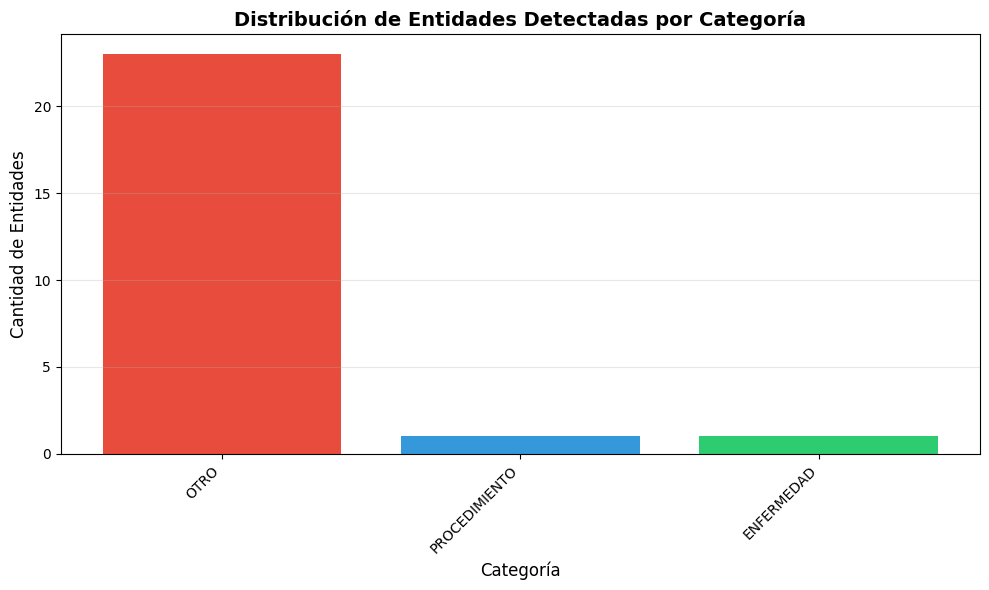

In [22]:
# Gráfico de distribución de categorías
if resultados['estadisticas']:
    plt.figure(figsize=(10, 6))
    categorias = list(resultados['estadisticas'].keys())
    cantidades = list(resultados['estadisticas'].values())
    
    plt.bar(categorias, cantidades, color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6'])
    plt.xlabel('Categoría', fontsize=12)
    plt.ylabel('Cantidad de Entidades', fontsize=12)
    plt.title('Distribución de Entidades Detectadas por Categoría', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

## 1️⃣1️⃣ Exportar Resultados

In [23]:
# Exportar a JSON
output_filename = 'ner_avanzado_resultados.json'

with open(output_filename, 'w', encoding='utf-8') as f:
    json.dump(resultados, f, ensure_ascii=False, indent=2)

print(f"\n✅ Resultados exportados a: {output_filename}")
print(f"   Tamaño del archivo: {len(json.dumps(resultados))} bytes")


✅ Resultados exportados a: ner_avanzado_resultados.json
   Tamaño del archivo: 8417 bytes


In [24]:
# Mostrar JSON en formato legible (primeras líneas)
print("\n" + "="*60)
print("📄 VISTA PREVIA JSON (primeras 50 líneas)")
print("="*60 + "\n")

json_str = json.dumps(resultados, ensure_ascii=False, indent=2)
lineas = json_str.split('\n')
for linea in lineas[:100]:
    print(linea)

if len(lineas) > 100:
    print(f"\n... ({len(lineas) - 50} líneas más) ...")


📄 VISTA PREVIA JSON (primeras 50 líneas)

{
  "metadatos": {
    "fecha_procesamiento": "2026-01-28T22:29:49.439477",
    "modelos_usados": [
      "d4data/biomedical-ner-all",
      "en_core_sci_scibert",
      "en_ner_bc5cdr_md"
    ],
    "knowledge_base": "UMLS"
  },
  "texto_original": "\nPaciente varón de 65 años, acude a emergencia por cuadro de 3 días de evolución caracterizado por disnea de medianos esfuerzos y dolor torácico opresivo.\nAntecedentes: Hipertensión arterial diagnosticada hace 10 años y Diabetes Mellitus tipo 2.\nActualmente en tratamiento con Losartán 50mg cada 12 horas y Metformina 850mg una vez al día.\nAl examen físico: PA 150/90 mmHg, FC 95 lpm. Murmullo vesicular disminuido en bases.\nNiega alergias a medicamentos conocidos. Se descarta infarto agudo de miocardio por enzimas cardiacas negativas.\n",
  "entidades_por_categoria": {
    "OTRO": [
      {
        "texto_original": "Paciente",
        "tipo_ner": "ENTITY",
        "posicion": [
          1,
   

## 🎯 Resumen y Conclusiones

### ✅ Logros

1. **Multi-modelo NER**: Combinación de Hugging Face + scispacy para máxima cobertura
2. **EntityLinker UMLS**: Vinculación a base de conocimiento médico con 3M+ conceptos
3. **Clasificación automática**: Por tipo semántico (TUI) - enfermedades, síntomas, medicamentos
4. **Enriquecimiento**: IDs normalizados, definiciones, sinónimos
5. **Detección de contexto**: Temporal, negación, certeza
6. **Expansión de abreviaturas**: Automática con AbbreviationDetector

### 📊 Aplicaciones

- **Estructuración de historias clínicas**: Texto libre → JSON estructurado
- **Sistemas de soporte diagnóstico**: Identificación de entidades relevantes
- **Interoperabilidad**: IDs UMLS estándares para integración con otros sistemas
- **Análisis epidemiológico**: Extracción masiva de datos de historias clínicas
- **Investigación clínica**: Identificación de cohort es y patrones

### 🚀 Próximos Pasos

1. Añadir RxNorm para mejor cobertura de medicamentos
2. Implementar extracción de relaciones (medicamento → enfermedad)
3. Fine-tuning de modelos con datos clínicos locales
4. Integración con sistemas de historias clínicas electrónicas
5. Validación con conjunto de datos anotado manualmente